# Fraser River Plume Through ONC's HF Radar and Ferry Data

In this example we will be using a suite of instruments and platforms to describe the Fraser River Plume as it is advected south on 2025-09-18.

During this time, ONC had instruments installed on the [British Columbia Ferry Spirit of Vancouver Island](https://www.bcferries.com/on-the-ferry/our-fleet/spirit-of-vancouver-island/SOVI) and a suite of [High Frequency radar systems](https://www.oceannetworks.ca/data/data-dashboards/real-time-surface-currents-data/) along the coastline. The ferry maintains instruments that provide sea surface temperature, salinity, chlorophyll-a, CDOM, turbidity, and dissolved oxygen, while the HF Radar coastal aggregate provides surface current vectors.

Accessing data from [NASA's Plankton, Aerosol, Cloud ocean Ecosystem](https://pace.gsfc.nasa.gov/) satellite allows us to resolve the Fraser River plume on a broader geographic scale using remotely sensed apparent optical properties (AOPs). Remote surface reflectance at 555nm may be used to aid in the identification of turbid river plumes ([Saldías et al., 2016](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015JC011431))



## Setup

This example requires accessing and downloading data from Ocean Networks Canada and NASA EarthData. These repositories require the use of a token or login/password to request data.
The setup and helper functions detailed below rely on the use of a .netrc file in your home directory to hold on to this information.

The .netrc entries for ONC and EarthData access should look like the following.

```
machine urs.earthdata.nasa.gov
login <your earth login>
password <your earthdata password>

machine data.oceannetworks.ca
login <your login>
password <your onc token>
```

The following third-party packages are needed for this example.

In [1]:
# !pip install cartopy
# !pip install gsw
# !pip install hypercoast
# !pip install matplotlib
# !pip install numpy
# !pip install onc
# !pip install pandas
# !pip install scipy
# !pip install xarray

In [2]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from datetime import datetime, timedelta
import glob
import gsw
import hypercoast
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from netrc import netrc
import numpy as np
from numpy.typing import ArrayLike
from onc import ONC
import os
import pandas as pd
import re
from scipy.interpolate import griddata
import xarray as xr

from pcn_common import format_datetime, convert_scalar_data

In [3]:
# Where to store data relative to notebook location.
save_dir = '../data'

In [4]:
_, __, onc_token = netrc().authenticators('data.oceannetworks.ca')
onc = ONC(token = onc_token,outPath = save_dir)

In [5]:
# The notebook may pause here if you haven't set up a _netrc file too.
hypercoast.nasa_earth_login()

In [6]:
sat_date_from = datetime(2025,9,18,20,00,0,0)
sat_date_to = datetime(2025,9,18,20,30,59,999999)

ferry_date_from = datetime(2025,9,18,21,45)
ferry_date_to = datetime(2025,9,18,23,30)

lat_min = 48.6
lat_max = 49.3
lon_min = -123.6
lon_max = -122.85
pace_bbox = [lon_min,lat_min, lon_max, lat_max] # Set extent for finding PACE L2 files.
proj_extent = [lon_min, lon_max, lat_min, lat_max] # Set extent for plots.

In [7]:
proj = ccrs.PlateCarree()
tile = cimgt.GoogleTiles(style = 'satellite')

## PACE Helper Functions

In [8]:
def grid_L2(da: xr.DataArray,
            lat_min: float, lat_max: float,
            lon_min: float, lon_max: float,
            bin_size: float = 0.01,
            central_buffer: float = 0.005,
            method: str = 'linear') -> xr.Dataset:
    """
    Grid a PACE L2 data product to common bins.
    :param da: The input data product.
    :param lat_min: The minimum latitude to grid to.
    :param lat_max: The maximum latitude to grid to.
    :param lon_min: The minimum longitude to grid to.
    :param lon_max: The maximum longitude to grid to.
    :param bin_size: The grid bin size.
    :param central_buffer: A buffer to provide for fine-tuning bin centers.
    :param method: The method for interpolating to the grid.
    :return: A gridded data product.
    """

    try:
        da = da.where((da.latitude > lat_min) & (da.latitude < lat_max) & (da.longitude > lon_min) & (da.longitude < lon_max), drop = True)
    except:
        return None
    if da.shape == (0,0):
        return None
    grid_lat = np.arange(np.round(lat_min - central_buffer,2), np.round(lat_max + central_buffer,2), bin_size)
    grid_lon = np.arange(np.round(lon_min - central_buffer,2),np.round(lon_max + central_buffer,2), bin_size)
    lon2d, lat2d = np.meshgrid(grid_lon, grid_lat)
    gd = griddata((da.latitude.data.flatten(), da.longitude.data.flatten()),da.data.flatten(),(lat2d, lon2d),method=method)
    gds = xr.Dataset({da.name:(['latitude','longitude'], gd)}, coords = {'latitude':grid_lat, 'longitude':grid_lon})
    return gds

## Download and Process Data

### ONC HF Radar Data


In [9]:
loc_code = 'SOGCS'
dev_cat_code = 'OCEANOGRAPHICRADAR'
data_prod_code = 'CODARQCSC'
extension = 'nc'

params = {'locationCode': loc_code,
          'deviceCategoryCode': dev_cat_code,
          'dataProductCode': data_prod_code,
          'extension': extension,
          'dateFrom': format_datetime(ferry_date_from),
          'dateTo': format_datetime(ferry_date_to)}

req = onc.requestDataProduct(params)
status = onc.checkDataProduct(req['dpRequestId'])
run = onc.runDataProduct(req['dpRequestId'])
download_info = [onc.downloadDataProduct(run_id, overwrite = True) for run_id in run['runIds']]
hf_files = [os.path.join(save_dir,file_info['file']) for files in download_info for file_info in files if file_info['file'].endswith('.nc')]
hf = xr.combine_by_coords([xr.open_dataset(f) for f in hf_files], combine_attrs = 'drop_conflicts')

hf['speed'] = (hf.u**2 + hf.v**2)**0.5
hf = hf.sel(time = ferry_date_from, method = 'nearest')

Request Id: 28531109
Estimated File Size: 246 kB
Estimated Processing Time: 20 s
To cancel the running data product, run 'onc.cancelDataProduct(28531109)'

   queued
   data product running...........
   1 files generated for this data product
   complete


   Search complete, waiting on the file system to synchronize (StraitofGeorgia_StraitofGeorgiaCODARSystem_OceanographicRadarSystem_20250918T220000.000Z_20250918T230000.000Z-Totals_Clean.nc)...............................

### ONC Ferry Data

In [10]:
class BCFTerminal:
    class Tsawwassen:
        latitude: float = 49.006621
        longitude: float = -123.132309

    class SwartzBay:
        latitude: float = 48.689047
        longitude: float = -123.410817

#### Tsawwassen to Swartz Bay Ferry Route

In [11]:
loc_code = 'TWSB'
dev_cat_codes = ['NAV','PVCS','TSG','TURBCHLFL','OXYSENSOR']

dss = []
for dev_cat_code in dev_cat_codes:
    params = {'locationCode': loc_code,
              'deviceCategoryCode': dev_cat_code,
              'dateFrom': format_datetime(ferry_date_from),
              'dateTo': format_datetime(ferry_date_to),
              'qualityControl': 'clean',
              'metadata':'Full',
              'fillGaps': False}
    if dev_cat_code == 'NAV':
        try:
            params['locationCode'] = '.'.join((loc_code, 'N1'))
            json_response = onc.getScalardata(params, allPages = True)
        except:
            params['locationCode'] = '.'.join((loc_code, 'N2'))
            json_response = onc.getScalardata(params, allPages = True)
    else:
        json_response = onc.getScalardata(params, allPages = True)
    _ds = convert_scalar_data(json_response)
    if dev_cat_code == 'OXYSENSOR':
        _ds = _ds.rename({'temperature':'optode_temperature','qaqc_flag_temperature':'qaqc_flag_optode_temperature'})
    dss.append(_ds)

# Merge datasets.
twsb = xr.combine_by_coords(dss, combine_attrs='drop_conflicts')
twsb = twsb.drop_vars([dv for dv in twsb.data_vars if dv.startswith('qaqc_flag_')], errors = 'ignore')

# Interpolate some variables to make cleaning data easier.
lvars = ['latitude', 'longitude', 'pump_current','outlet_flow']
nvars = ['system_state','valve_position']
for lvar in lvars:
    twsb[lvar] = twsb[lvar].interpolate_na(dim='time', method='linear', fill_value="extrapolate", max_gap=timedelta(seconds = 5))
for nvar in nvars:
    twsb[nvar] = twsb[nvar].interpolate_na(dim='time', method='nearest', max_gap=timedelta(seconds = 5))

# Remove data if the system was not on, open, or if flow was poor.
twsb = twsb.where(twsb['system_state'] == 1, drop = True)
twsb = twsb.where(twsb['valve_position'] == 1, drop = True)
twsb = twsb.where(twsb['pump_current'] > 1, drop = True)
twsb = twsb.where(twsb['outlet_flow'] > 1, drop = True)

# Calculate density using an estimated pressure of 3 dbar.
sa = gsw.SA_from_SP(twsb.practical_salinity, 3, twsb.longitude, twsb.latitude)
ct = gsw.CT_from_t(sa, twsb.temperature, 3)
twsb['density'] = gsw.rho(sa, ct, 3)

# Clean up the transit.
twsb = twsb[['latitude','longitude','chlorophyll','cdom_fluorescence','turbidity','oxygen_concentration_corrected','temperature','practical_salinity','density']]
twsb = twsb.sel(time = slice(twsb.time.min() + np.timedelta64(300,'s'), twsb.time.max()-np.timedelta64(60,'s')))
twsb = twsb.resample({'time': '5s'}).mean()
twsb = twsb.rolling({'time': 13}, center = True).median(skipna = True)
twsb = twsb.dropna(dim = 'time', how = 'all')

### Download PACE and Import PACE

In [12]:
temporal = (format_datetime(sat_date_from), format_datetime(sat_date_to))
short_names = ['PACE_OCI_L2_AOP_NRT']
for short_name in short_names:
    results = hypercoast.search_pace(instrument = 'oci',
                                     bbox = pace_bbox,
                                     temporal = temporal,
                                     short_name = short_name)
    hypercoast.download_nasa_data(results, save_dir)

aop_files = glob.glob(os.path.join(save_dir,'*AOP*.nc'))
aop_file = aop_files[0]

# Import data and select Rrs at 555nm.
aop = hypercoast.read_pace(aop_file)
aop = grid_L2(aop.sel(wavelength = 555, method = 'nearest')['Rrs'], lat_min, lat_max, lon_min, lon_max)

# Get the swath time.
aop_time = datetime.strptime(re.findall('(\d{8}T\d{6})',aop_file)[0],'%Y%m%dT%H%M%S').strftime('%Y-%m-%d %H00')

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

## Figures

### Figure 1

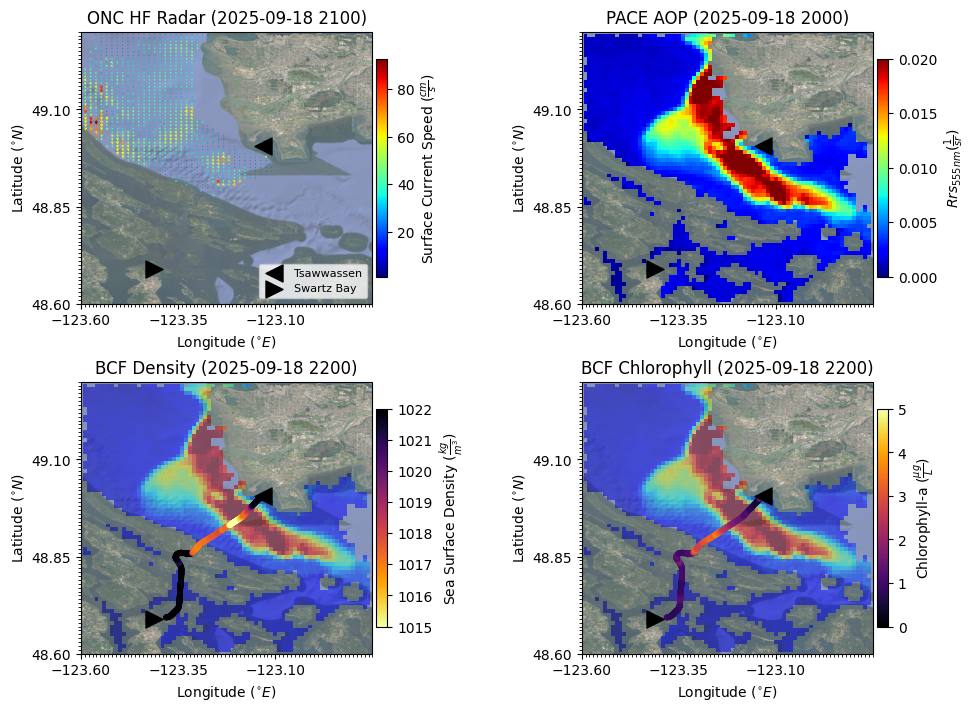

In [13]:
# Figure Parameters
nrow = 2
ncol = 2
figsize = (10,7)

# Tick Spacing
major_locator = 0.25
minor_locator = 0.01

fig, ax = plt.subplots(nrow, ncol, figsize = figsize, constrained_layout = True, subplot_kw = {'projection': proj})
for i,j in product(range(nrow), range(ncol)):

    # Set Background
    ax[i,j].set_extent(proj_extent)
    ax[i,j].add_image(tile,12,alpha = 0.67)

    # Format Longitude Axes
    ax[i,j].set_xlabel(r'Longitude ($^{\circ}E$)')
    ax[i,j].set_xticks(np.arange(lon_min, lon_max,major_locator))
    ax[i,j].xaxis.set_minor_locator(MultipleLocator(minor_locator))

    # Format Latitude Axes
    ax[i,j].set_ylabel(r'Latitude ($^{\circ}N$)')
    ax[i,j].set_yticks(np.arange(lat_min, lat_max,major_locator))
    ax[i,j].yaxis.set_minor_locator(MultipleLocator(minor_locator))

    # Add BCF Terminal Locations
    ax[i,j].scatter(BCFTerminal.Tsawwassen.longitude, BCFTerminal.Tsawwassen.latitude, s = 150, marker = '<', c = 'k', edgecolors = 'k', label = 'Tsawwassen',zorder = 2)
    ax[i,j].scatter(BCFTerminal.SwartzBay.longitude, BCFTerminal.SwartzBay.latitude, s = 150, marker = '>', c = 'k', edgecolors = 'k', label = 'Swartz Bay', zorder = 2)


# Plot HF Radar Data
ax[0,0].set_title(f'ONC HF Radar ({pd.to_datetime(hf.time.mean().values).strftime('%Y-%m-%d %H00')})')
quiv00 = ax[0,0].quiver(hf.lon, hf.lat, hf.u, hf.v, hf.speed, cmap = 'jet', transform = proj, angles = 'xy', pivot = 'mid', headwidth = 5)
fig.colorbar(quiv00, ax = ax[0,0], label = r'Surface Current Speed ($\frac{cm}{s}$)', orientation = 'vertical', pad = 0.01, shrink = 0.8)
ax[0,0].legend(loc = 'lower right', fontsize = 8)


ax[0,1].set_title(f'PACE AOP ({aop_time})')
pmesh01 = ax[0,1].pcolormesh(aop.longitude, aop.latitude, aop.Rrs, cmap = 'jet', transform = proj, vmin = 0, vmax = 0.02)
fig.colorbar(pmesh01, ax = ax[0,1], label = r'$Rrs_{555nm} (\frac{1}{sr})$', orientation = 'vertical', pad = 0.01, shrink = 0.8)

ax[1,0].set_title(f'BCF Density ({pd.to_datetime(twsb.time.mean().values).strftime('%Y-%m-%d %H00')})')
pmesh10 = ax[1,0].pcolormesh(aop.longitude, aop.latitude, aop.Rrs, cmap = 'jet', transform = proj, vmin = 0, vmax = 0.02,alpha = 0.5)
s10 = ax[1,0].scatter(twsb.longitude, twsb.latitude, c = twsb.density, cmap = 'inferno_r', transform = proj, vmin = 1015, vmax = 1022, s = 10)
fig.colorbar(s10, ax = ax[1,0], label = r'Sea Surface Density ($\frac{kg}{m^3}$)', orientation = 'vertical', pad = 0.01, shrink = 0.8)

ax[1,1].set_title(f'BCF Chlorophyll ({pd.to_datetime(twsb.time.mean().values).strftime('%Y-%m-%d %H00')})')
pmesh10 = ax[1,1].pcolormesh(aop.longitude, aop.latitude, aop.Rrs, cmap = 'jet', transform = proj, vmin = 0, vmax = 0.02, alpha = 0.5)
s11 = ax[1,1].scatter(twsb.longitude, twsb.latitude, c = twsb.chlorophyll, vmin = 0, vmax = 5, cmap = 'inferno', transform = proj, s = 10)
fig.colorbar(s11, ax = ax[1,1], label = r'Chlorophyll-a ($\frac{{\mu}g}{L}$)', orientation = 'vertical', pad = 0.01, shrink = 0.8)

### Figure 2

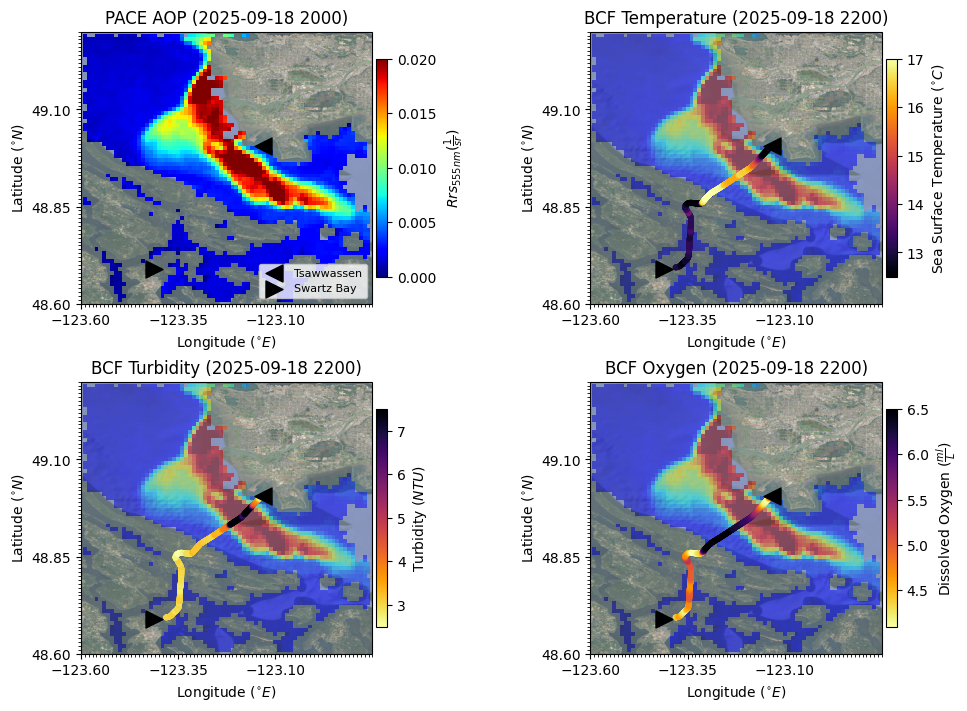

In [14]:
# Figure Parameters
nrow = 2
ncol = 2
figsize = (10,7)

# Tick Spacing
major_locator = 0.25
minor_locator = 0.01

fig, ax = plt.subplots(nrow, ncol, figsize = figsize, constrained_layout = True, subplot_kw = {'projection': proj})
for i,j in product(range(nrow), range(ncol)):

    # Set Background
    ax[i,j].set_extent(proj_extent)
    ax[i,j].add_image(tile,12,alpha = 0.67)

    # Format Longitude Axes
    ax[i,j].set_xlabel(r'Longitude ($^{\circ}E$)')
    ax[i,j].set_xticks(np.arange(lon_min, lon_max,major_locator))
    ax[i,j].xaxis.set_minor_locator(MultipleLocator(minor_locator))

    # Format Latitude Axes
    ax[i,j].set_ylabel(r'Latitude ($^{\circ}N$)')
    ax[i,j].set_yticks(np.arange(lat_min, lat_max,major_locator))
    ax[i,j].yaxis.set_minor_locator(MultipleLocator(minor_locator))

    # Add BCF Terminal Locations
    ax[i,j].scatter(BCFTerminal.Tsawwassen.longitude, BCFTerminal.Tsawwassen.latitude, s = 150, marker = '<', c = 'k', edgecolors = 'k', label = 'Tsawwassen',zorder = 2)
    ax[i,j].scatter(BCFTerminal.SwartzBay.longitude, BCFTerminal.SwartzBay.latitude, s = 150, marker = '>', c = 'k', edgecolors = 'k', label = 'Swartz Bay', zorder = 2)

ax[0,0].set_title(f'PACE AOP ({aop_time})')
pmesh00 = ax[0,0].pcolormesh(aop.longitude, aop.latitude, aop.Rrs, cmap = 'jet', transform = proj, vmin = 0, vmax = 0.02)
fig.colorbar(pmesh00, ax = ax[0,0], label = r'$Rrs_{555nm} (\frac{1}{sr})$', orientation = 'vertical', pad = 0.01, shrink = 0.8)
ax[0,0].legend(loc = 'lower right', fontsize = 8)

ax[0,1].set_title(f'BCF Temperature ({pd.to_datetime(twsb.time.mean().values).strftime('%Y-%m-%d %H00')})')
pmesh01 = ax[0,1].pcolormesh(aop.longitude, aop.latitude, aop.Rrs, cmap = 'jet', transform = proj, vmin = 0, vmax = 0.02,alpha = 0.5)
s01 = ax[0,1].scatter(twsb.longitude, twsb.latitude, c = twsb.temperature, cmap = 'inferno', transform = proj, vmin = 12.5, vmax = 17, s = 10)
fig.colorbar(s01, ax = ax[0,1], label = r'Sea Surface Temperature ($^{\circ}C$)', orientation = 'vertical', pad = 0.01, shrink = 0.8)

ax[1,0].set_title(f'BCF Turbidity ({pd.to_datetime(twsb.time.mean().values).strftime('%Y-%m-%d %H00')})')
pmesh10 = ax[1,0].pcolormesh(aop.longitude, aop.latitude, aop.Rrs, cmap = 'jet', transform = proj, vmin = 0, vmax = 0.02, alpha = 0.5)
s10 = ax[1,0].scatter(twsb.longitude, twsb.latitude, c = twsb.turbidity, vmin = 2.5, vmax = 7.5, cmap = 'inferno_r', transform = proj, s = 10)
fig.colorbar(s10, ax = ax[1,0], label = r'Turbidity ($NTU$)', orientation = 'vertical', pad = 0.01, shrink = 0.8)

ax[1,1].set_title(f'BCF Oxygen ({pd.to_datetime(twsb.time.mean().values).strftime('%Y-%m-%d %H00')})')
pmesh10 = ax[1,1].pcolormesh(aop.longitude, aop.latitude, aop.Rrs, cmap = 'jet', transform = proj, vmin = 0, vmax = 0.02, alpha = 0.5)
s11 = ax[1,1].scatter(twsb.longitude, twsb.latitude, c = twsb.oxygen_concentration_corrected, vmin = 4.1, vmax = 6.5, cmap = 'inferno_r', transform = proj, s = 10)
fig.colorbar(s11, ax = ax[1,1], label = r'Dissolved Oxygen ($\frac{ml}{L}$)', orientation = 'vertical', pad = 0.01, shrink = 0.8)